In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torchvision import transforms
from PIL import Image
convert_tensor = transforms.ToTensor()
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
images = []
import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        if filename.find(".jpg") != -1:
            if random.random() > 0.5:
                images.append(convert_tensor(Image.open(dirname + "/" + filename)))
images = torch.stack(images)
print(images.shape)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

torch.Size([3707, 3, 256, 256])


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
images = images.view(images.shape[0], -1).to(device) / 255

In [4]:
import torchvision

In [5]:
import torch.nn as nn

In [32]:
class GAN(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.picasso = nn.Sequential(
            nn.BatchNorm1d(in_size),
            nn.Linear(in_size, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, out_size),
            nn.Sigmoid()
        )
        self.critic = nn.Sequential(
            nn.Linear(out_size, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 1),
            
            nn.Sigmoid()
        )
    def forward(self, ins):
        return self.picasso(ins)
    def gan_forward(self, ins):
        return self.critic(ins)
    def __call__(self, ins):
        return self.forward(ins)

In [54]:
net = GAN(3*256*256, 3 * 256 * 256).to(device)

In [55]:
net.gan_forward(net(images[0:10]))

tensor([[0.5002],
        [0.5002],
        [0.5002],
        [0.5002],
        [0.5002],
        [0.5002],
        [0.5002],
        [0.5002],
        [0.5002],
        [0.5002]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [56]:
num_epochs = 24
batch_size = 16
train_len = len(images)
num_steps = (train_len//batch_size) * num_epochs
lr = 0.0001
optimG = torch.optim.AdamW(net.picasso.parameters(), lr=lr)
optimD = torch.optim.Adam(net.critic.parameters(), lr=lr)

In [57]:
stepi = torch.arange(num_steps)
glossi = []
dlossi = []

Step 0, loss D: 0.6872255802154541, loss G: 0.8358616232872009


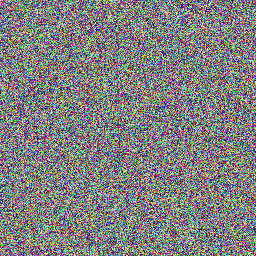

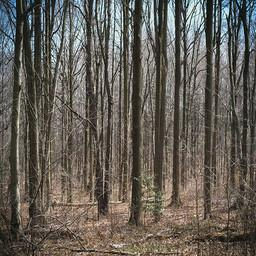

Step 1000, loss D: 0.20848163962364197, loss G: 1.0


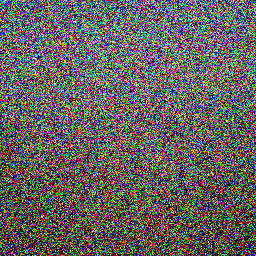

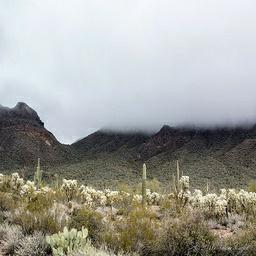

Step 2000, loss D: 0.08263962715864182, loss G: 1.0


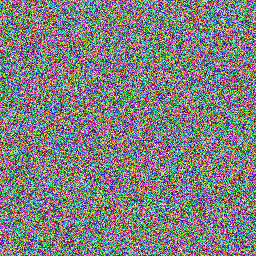

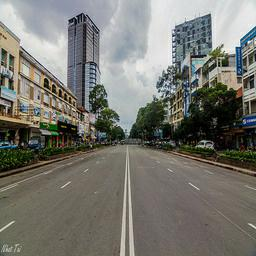

Step 3000, loss D: 0.1837175190448761, loss G: 1.0


In [ ]:
for step in range(num_steps):
    batch_indices = torch.randint(1, train_len-1, (batch_size//2,))
    d_batch_real = images[batch_indices]
    d_batch_gen = net(images[batch_indices]).detach()
    d_batch = torch.cat((d_batch_real, d_batch_gen)).to(device)
    d_ys = torch.cat((torch.zeros(batch_size//2, 1), torch.ones(batch_size//2, 1))).to(device)
    d_out = net.gan_forward(d_batch)
    
    d_loss = nn.functional.binary_cross_entropy(d_out, d_ys)
    optimD.zero_grad()
    d_loss.backward()
    optimD.step()
    
    batch_indices = torch.randint(1, train_len-1, (batch_size//2,))
    g_batch = images[batch_indices]
    g_out = net(g_batch)
    
    g_loss = net.gan_forward(g_out).sum() / len(g_out)
    optimG.zero_grad()
    g_loss.backward()
    optimG.step()
    
    glossi.append(g_loss.item())
    dlossi.append(d_loss.item())
    if step % 1000 == 0:
        print("Step", str(step) + ", loss D:", str(d_loss.item()) + ", loss G:", g_loss.item())
        with torch.no_grad():
            noise = images[torch.randint(0, train_len-1, (2,))]
            res = net(noise)[0].view(3, 256, 256)
            display(torchvision.transforms.functional.to_pil_image(res * 255), torchvision.transforms.functional.to_pil_image(noise[0].view(3, 256, 256) * 255))

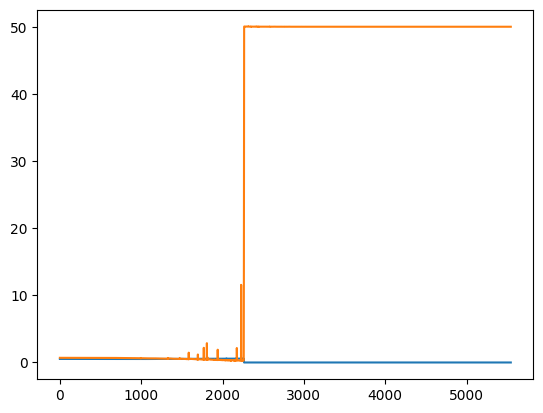

In [12]:
import matplotlib.pyplot as plt
plt.plot(stepi, glossi, label='g loss')
plt.plot(stepi, dlossi, label='d loss')
plt.show()

In [13]:
with torch.no_grad():
    for x in range(5):
        ins = torch.randn(1, 3* 256 * 256).to(device)
        net_out = net(ins).view(3, 256, 256)
        image = torchvision.transforms.functional.to_pil_image(net_out)
        display(image)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 196608])

In [ ]:
#import zipfile
#from PIL import Image

# Create a ZipFile object
#with zipfile.ZipFile('images.zip', 'w') as zip_file:
    # Iterate over the PIL images
#    for x in range(8000):
#        seed = torch.randn(16).to(device)
#        out = net(seed).view(3, 256, 256)
#        image = torchvision.transforms.functional.to_pil_image(out)
#        # Write the image to the zip file
#        zip_file.writestr("image_" + str(x) + ".jpg", image.tobytes())

# Close the ZipFile object
#zip_file.close()

In [ ]:
! mkdir ../images

for i in range(8000):
    seed = torch.randn(16).to(device)
    out = net(seed).view(3, 256, 256)
    image = torchvision.transforms.functional.to_pil_image(out)
    image.save("../images/" + str(i) + ".jpg")
    i += 1
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")